<a href="https://colab.research.google.com/github/rmahesh6386/Tata-Motors-Project-/blob/main/TATA_Motors_Stock_market_Forecasting_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

plt.style.use("ggplot")

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (12, 6)

In [4]:
# For reading stock data from yahoo
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

# For time stamps
from datetime import datetime

# For division
from __future__ import division

In [5]:
#stock Company for analytics
stock = ['TATAMOTORS.NS']
data_source = 'yahoo' 

# set up Start and End time for data grab
end = datetime.now()
start = datetime(end.year-10,end.month,end.day)

# Set DataFrame as the Stock Ticker
df = pdr.get_data_yahoo(stock,start,end)

[*********************100%***********************]  1 of 1 completed


In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-07-27,208.266144,213.114136,206.979935,210.591202,208.192703,11852257
2012-07-30,214.103531,220.435608,213.064667,219.347275,216.849060,9094027
2012-07-31,219.644104,224.591034,214.845566,223.848999,221.299500,11297966
2012-08-01,222.167038,227.262390,220.831360,224.937317,222.375412,10425962
2012-08-02,223.700592,224.591034,219.248337,220.336670,217.827179,5808700


In [7]:
df.index

DatetimeIndex(['2012-07-27', '2012-07-30', '2012-07-31', '2012-08-01',
               '2012-08-02', '2012-08-03', '2012-08-06', '2012-08-07',
               '2012-08-08', '2012-08-09',
               ...
               '2022-07-14', '2022-07-15', '2022-07-18', '2022-07-19',
               '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-25',
               '2022-07-26', '2022-07-27'],
              dtype='datetime64[ns]', name='Date', length=2464, freq=None)

Check whether you have duplicate data on by date

In [8]:
df[df.index.duplicated(keep = False)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


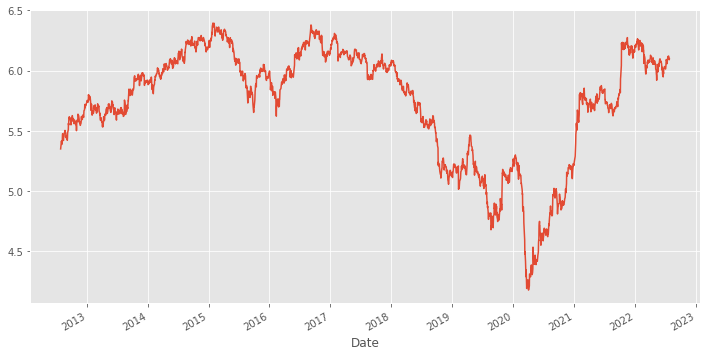

In [9]:
y = np.log(df["Close"])
y.plot()

In [37]:
y.index

DatetimeIndex(['2012-07-27', '2012-07-30', '2012-07-31', '2012-08-01',
               '2012-08-02', '2012-08-03', '2012-08-06', '2012-08-07',
               '2012-08-08', '2012-08-09',
               ...
               '2022-07-14', '2022-07-15', '2022-07-18', '2022-07-19',
               '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-25',
               '2022-07-26', '2022-07-27'],
              dtype='datetime64[ns]', name='Date', length=2464, freq=None)

Let's see if there are gaps in the data in terms of date range. Trading does not happen on weekends or national holidays. So there is no data on those days.

In [11]:
list(y.index[:10])

[Timestamp('2012-07-27 00:00:00'),
 Timestamp('2012-07-30 00:00:00'),
 Timestamp('2012-07-31 00:00:00'),
 Timestamp('2012-08-01 00:00:00'),
 Timestamp('2012-08-02 00:00:00'),
 Timestamp('2012-08-03 00:00:00'),
 Timestamp('2012-08-06 00:00:00'),
 Timestamp('2012-08-07 00:00:00'),
 Timestamp('2012-08-08 00:00:00'),
 Timestamp('2012-08-09 00:00:00')]

In [38]:
y.asfreq("D")[:15]

Date
2012-07-27    5.349919
2012-07-28         NaN
2012-07-29         NaN
2012-07-30    5.390656
2012-07-31    5.410972
2012-08-01    5.415822
2012-08-02    5.395157
2012-08-03    5.387268
2012-08-04         NaN
2012-08-05         NaN
2012-08-06    5.423271
2012-08-07    5.464957
2012-08-08    5.476201
2012-08-09    5.467049
2012-08-10    5.435853
Freq: D, Name: Close, dtype: float64

Let's impute the missing data by forward fill using asfreq method.

In [39]:
y.asfreq("D", method="ffill")[:15]

Date
2012-07-27    5.349919
2012-07-28    5.349919
2012-07-29    5.349919
2012-07-30    5.390656
2012-07-31    5.410972
2012-08-01    5.415822
2012-08-02    5.395157
2012-08-03    5.387268
2012-08-04    5.387268
2012-08-05    5.387268
2012-08-06    5.423271
2012-08-07    5.464957
2012-08-08    5.476201
2012-08-09    5.467049
2012-08-10    5.435853
Freq: D, Name: Close, dtype: float64

Calculate rolling mean, exponentially weighted mean

In [40]:
period = 100
y_rolling = pd.DataFrame(dict(actual = y, 
                              rolling_mean = y.rolling(period).mean(), 
                              ewm = y.ewm(span = period).mean()
                             ))
y_rolling.tail()

,actual,rolling_mean,ewm
Date,,,
2022-07-21,6.119968,6.052305,6.060416
2022-07-22,6.120078,6.052198,6.061597
2022-07-25,6.108247,6.052099,6.062521
2022-07-26,6.089385,6.051954,6.063053
2022-07-27,6.095937,6.052111,6.063704


In [41]:
rolling_dropped = y_rolling.dropna()
print("rmse over rolling mean: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped.rolling_mean) ** 0.5)
print("rmse over ewma: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped["ewm"]) ** 0.5)

rmse over rolling mean:  0.18584831697866364
rmse over ewma:  0.15795918070246967


By visual inspection, we see the time series is not stationary. Let we will see a more formal way of testing using Dickey Fullter Test.

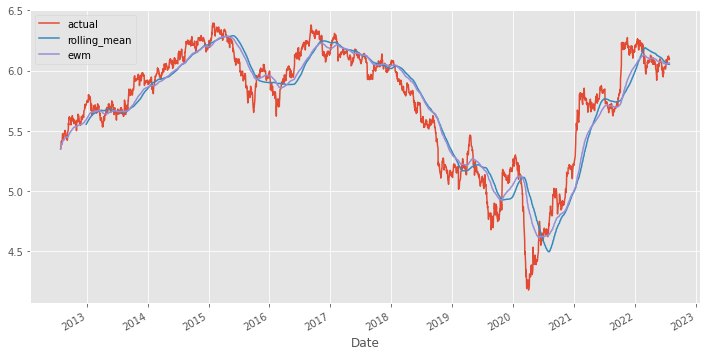

In [42]:
y_rolling.plot()

Formal of way of test for stationarity. Since the p-value of Augmented Dickey Fullter test is > 0.05, we can say that there is not sufficient proof that the time series is stationary. Loosely speaking, it is non-stationary. We need further transformation to make data stationary. Populary method for making data stationary will be to take "difference". Taking difference by lag one, we see the p-val for Dickey Fuller test is < 0.05. So we conclude, diff 1 has made the data stationary.

In [43]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(y.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.412390
p-value: 0.576322


In [44]:
diff = pd.DataFrame({"actual": y, "diff1": y.diff(3)}).head(10)
diff["diff2"] = diff.diff1.diff(1)
diff

,actual,diff1,diff2
Date,,,
2012-07-27,5.349919,NaN,NaN
2012-07-30,5.390656,NaN,NaN
2012-07-31,5.410972,NaN,NaN
2012-08-01,5.415822,0.065903,NaN
2012-08-02,5.395157,0.004500,-0.061402
2012-08-03,5.387268,-0.023704,-0.028205
2012-08-06,5.423271,0.007450,0.031154
2012-08-07,5.464957,0.069801,0.062351
2012-08-08,5.476201,0.088933,0.019132


In [45]:
result = adfuller(y.diff(periods=1).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -48.587787
p-value: 0.000000


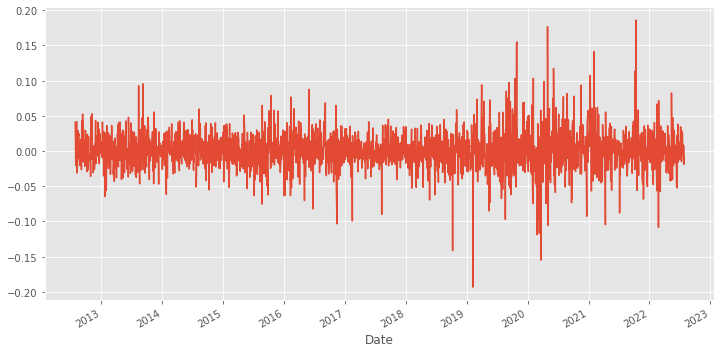

In [46]:
y.diff(periods=1).plot()

Use pandas's auto correlation plot. Here is a nice explanation of the autocorrelation plot

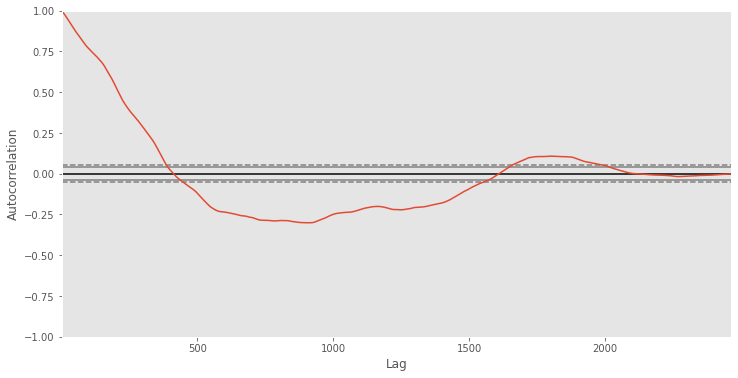

In [47]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y)

In [48]:
y = y.dropna()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                  0
count  2.463000e+03
mean  -3.284526e-07
std    2.684145e-02
min   -1.941632e-01
25%   -1.373291e-02
50%   -1.188830e-04
75%    1.333687e-02
max    1.855230e-01


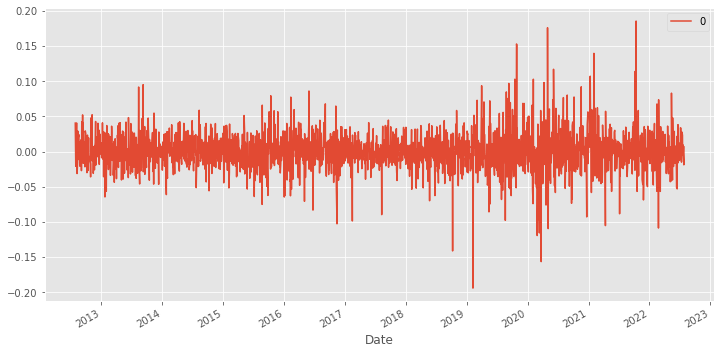

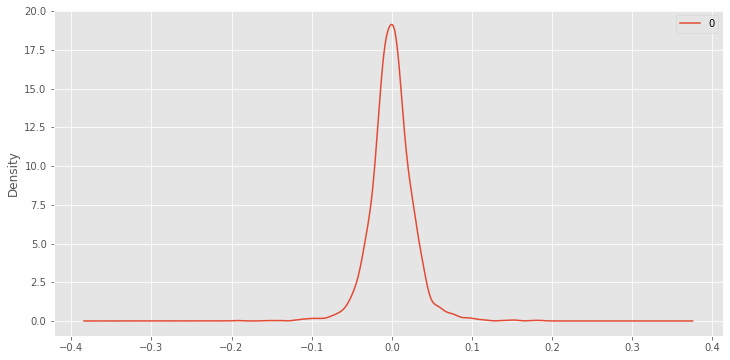

In [63]:
from statsmodels.tsa.arima_model import ARIMA

p=0
d=1
q=1

# fit model
model = ARIMA(y, order=(p, d, q)) 
model_fit = model.fit(disp=0)
#print(model_fit.summary())

# plot residual erros
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [51]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2463
Model:                 ARIMA(0, 1, 2)   Log Likelihood                5416.414
Method:                       css-mle   S.D. of innovations              0.027
Date:                Wed, 27 Jul 2022   AIC                         -10824.827
Time:                        12:02:37   BIC                         -10801.591
Sample:                             1   HQIC                        -10816.385
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.001      0.545      0.586      -0.001       0.001
ma.L1.D.Close     0.0209      0.020      1.035      0.301      -0.019       0.060
ma.L2.D.Close     0.0089      0.020      0.443      0.658      -0.031       0.048
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.1714          -10.5313j           10.5963           -0.2676
MA.2           -1.1714          +10.5313j           10.5963            0.2676
-----------------------------------------------------------------------------
"""

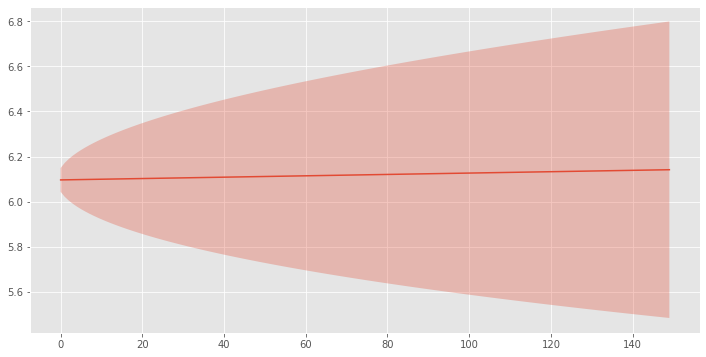

In [64]:
model = ARIMA(y.values, order=(p, d, q))
model_fit = model.fit(disp=0)
predictions, error, conf_interval = model_fit.forecast(150)
plt.plot(predictions)
plt.fill_between(range(len(predictions)), conf_interval[:,0], conf_interval[:,1], alpha = 0.3)

In [65]:
predictions[:10]

array([6.09637769, 6.09668097, 6.09698425, 6.09728753, 6.09759081,
       6.09789409, 6.09819738, 6.09850066, 6.09880394, 6.09910722])

In [66]:
error[:10]

array([0.026836  , 0.03834612, 0.04712409, 0.05450628, 0.06100154,
       0.06686885, 0.07226131, 0.0772784 , 0.08198906, 0.0864434 ])

In [55]:
conf_interval[:10]

array([[6.04361756, 6.14880855],
       [6.02141539, 6.1717379 ],
       [6.00423743, 6.18952277],
       [5.98987039, 6.20449671],
       [5.97728067, 6.21769335],
       [5.9659458 , 6.22963512],
       [5.95555808, 6.24062975],
       [5.94591814, 6.2508766 ],
       [5.93688808, 6.26051357],
       [5.92836778, 6.26964078]])

In [67]:
model.endog

array([ 0.04073738,  0.02031551,  0.00485006, ..., -0.01183055,
       -0.01886212,  0.0065522 ])

In [57]:
(predictions + 1.96 * error)[:10]

array([6.14880952, 6.17173928, 6.18952447, 6.20449868, 6.21769556,
       6.22963755, 6.24063237, 6.2508794 , 6.26051655, 6.26964392])

In [58]:
(predictions - 1.96 * error)[:10]

array([6.0436166 , 6.02141401, 6.00423573, 5.98986842, 5.97727846,
       5.96594338, 5.95555546, 5.94591534, 5.9368851 , 5.92836464])

predicted=4.862366, actual=4.872905
predicted=4.872948, actual=4.818263
predicted=4.816338, actual=4.808111
predicted=4.807551, actual=4.765587
predicted=4.763972, actual=4.820685
predicted=4.821949, actual=4.804431
predicted=4.803652, actual=4.803611
predicted=4.803295, actual=4.794964
predicted=4.794422, actual=4.798679
predicted=4.798474, actual=4.794136
predicted=4.793701, actual=4.819071
predicted=4.819435, actual=4.722064
predicted=4.719408, actual=4.679350
predicted=4.677855, actual=4.709981
predicted=4.710467, actual=4.705468
predicted=4.704966, actual=4.790404
predicted=4.792296, actual=4.756603
predicted=4.755465, actual=4.738827
predicted=4.738091, actual=4.759607
predicted=4.759759, actual=4.724286
predicted=4.723149, actual=4.695925
predicted=4.694923, actual=4.771108
predicted=4.772361, actual=4.797855
predicted=4.798121, actual=4.803201
predicted=4.803006, actual=4.900448
predicted=4.902492, actual=4.851640
predicted=4.850441, actual=4.864067
predicted=4.864026, actual=4

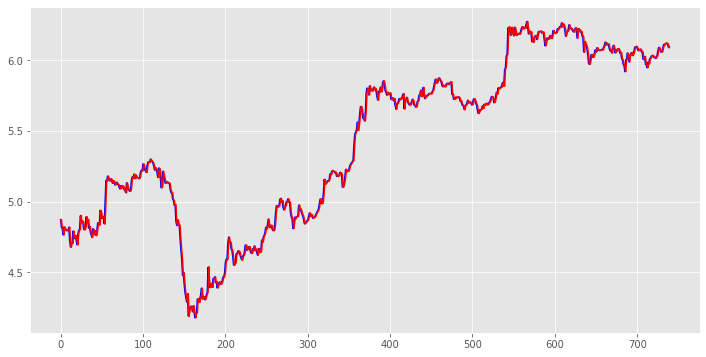

In [68]:
from sklearn.metrics import mean_squared_error

x = y.values
train_size = int(len(x) * 0.7)
train, test = x[0:train_size], x[train_size:]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, actual=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % np.sqrt(error))

plt.plot(test,color='blue')
plt.plot(predictions, color='red')

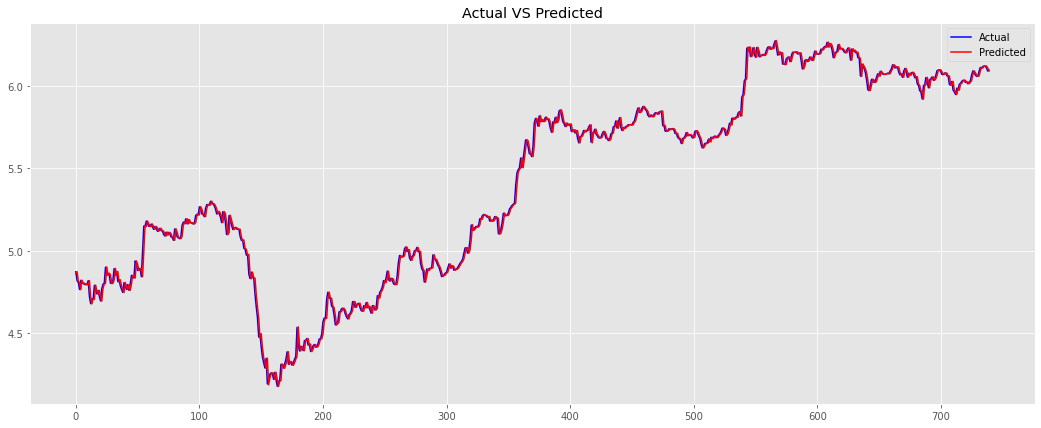

In [69]:
plt.figure(figsize=(18,7))
fig=plt.figure(1)
plt.plot(test,color='blue',label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.legend(loc = 'best')
plt.title('Actual VS Predicted')
plt.show(block = False)

In [70]:
result = pd.DataFrame(y)[train_size:]
result.columns = ["actual"]
result["prediction"] = predictions
result

,actual,prediction
Date,,
2019-08-02,4.872905,4.862366
2019-08-05,4.818263,4.872948
2019-08-06,4.808111,4.816338
2019-08-07,4.765587,4.807551
2019-08-08,4.820685,4.763972
...,...,...
2022-07-21,6.119968,6.117394
2022-07-22,6.120078,6.120334
2022-07-25,6.108247,6.120386
